# End-to-End notebook of MSci Project work

The following example notebooks were particularly useful for the following code:

1) Example method for translating numpy arrays into the h5USID format: https://pycroscopy.github.io/pyUSID/auto_examples/beginner/plot_numpy_translator.html

2) Handy visualisation tools from the pyUSID module:
https://pycroscopy.github.io/USID/auto_examples/plot_2D_image.html

3) Manipulation routines using Pycroscopy:
https://pycroscopy.github.io/pycroscopy/auto_examples/plot_fft_2d_filtering.html

This notebook is the amalgamation of much of the work I have been attempting as part of this MSci Project. All of my work can be found on my GitHub repo: https://github.com/sulaymandesai/MSciProject

## Importing modules

In [1]:
get_ipython().magic('reset -sf') # Clearing all variables and functions

In [3]:
# Import necessary libraries:
# General utilities:
import os
import sys
from time import time

# Packages for plotting and displaying images/data
import matplotlib.pyplot as plt
from PIL import Image
import spiepy

# set up notebook to show plots within the notebook
%matplotlib inline

# Computation:
import numpy as np
import h5py

# Finally, pycroscopy itself
sys.path.append('../../../')
import pycroscopy as px
import pyUSID as usid
import sidpy

import warnings
warnings.filterwarnings("ignore")

In [4]:
#Importing the flat file translator and flat file parser from a different directory 

# Recording default directory
default_dir = os.getcwd()

# Changing the flat file translator directory
translator_code_dir = '/Users/sulaymandesai/Documents/Year_4/MSciProject/Translator'
os.chdir(translator_code_dir)

# Importing and instantiating flat file translator class
from FlatFileTranslator import FlatFileTranslator
tran = FlatFileTranslator()

mtrx2flat_dir = '/Users/sulaymandesai/Documents/GitHub/STM_file_management'
os.chdir(mtrx2flat_dir)

# Flat File parser
from flatfile_3 import FlatFile

# Scienta Omicron MTRX file loader
import access2thematrix
mtrx = access2thematrix.MtrxData()

# Changing back to default dir
os.chdir(default_dir)

# Translating Flat Files and Mtrx files

I will demonstrate multiple methods to parse and translate flat and mtrx files. 

### Translating a folder of flat files and visualising the raw data

The method below will demonstrate how the FlatFileTranslator class (https://github.com/sulaymandesai/MSciProject/blob/master/Translator/FlatFileTranslator.py) translates a folder of flat files into h5 files. 

In [5]:
# Translating a directory of flat files and storing into a directory and accessing this using an array of filepaths

# Function to record time it takes to run code cell
t0 = time()

FlatFile_dir = '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/STM'

h5_path_dir = '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5'

# Storing h5 paths into arrays. Have to specify the flat file dir and h5 path dir
h5_path_array = tran.translate(FlatFile_dir, h5_path_dir)

print('Translation took {} seconds.'.format(round(time()-t0, 2)))

Translation took 5.75 seconds.


In [6]:
h5_path_array

['/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--27_1_up-fwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--27_1_up-bwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--27_1_down-fwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--27_1_down-bwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--11_1_up-fwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--11_1_up-bwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--11_1_down-fwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5/default_2017Jun09-162147_STM-STM_S

In [7]:
# Accessing file in r+ mode (to read and write to file if needed)
h5_file = h5py.File(h5_path_array[4], mode='r+') # Accessing the first filepath from the array

In [8]:
# Printing the datasets inside the h5 file
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


In [9]:
# Reading the main dataset. Could alternatively use usid.USIDataset()
h5_main = usid.hdf_utils.get_all_main(h5_file)[-1] # Finds all the main data sets. 
print(h5_main)

<HDF5 dataset "Raw_Data": shape (122500, 1), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	topo (m) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 350 
	X - size: 350 
Spectroscopic Dimensions: 
	None - size: 1
Data Type:
	float64


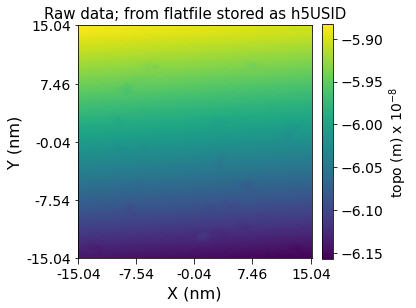

In [10]:
# Use pyUSID to visualise the image
usid.plot_utils.use_nice_plot_params()
fig, axis = h5_main.visualize(figsize=(6,6),num_ticks=5)
_ = axis.set_title('Raw data; from flatfile stored as h5USID', fontsize=15)

In [11]:
# Closing the flat file
h5_file.close()

### Translating individual flat files and visualising raw data

This section will consist of the translation of individual flat files using the Numpy translator example from the pyUSID page (https://pycroscopy.github.io/pyUSID/auto_examples/beginner/plot_numpy_translator.html). I will then visualise the data to verify the translation was completed correctly.

In [12]:
# Flat File directory
FlatFile_dir = '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/Z'

# h5 file directory
h5_dir = '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5'

# Name of image file to be analysed
imgFileName_11 = "default_2017Jun09-162147_STM-STM_Spectroscopy--11_1.Z_mtrx"
imgFileName_9 = 'default_2017Jun09-162147_STM-STM_Spectroscopy--9_1.Z_flat'
imgFileName_63 = 'default_2017Jun09-162147_STM-STM_Spectroscopy--63_1.Z_mtrx'

# Creating list of file names
imgFileName = [imgFileName_11, imgFileName_9, imgFileName_63]

In [13]:
# Creating empty array to store files full path
imgFullFileName = []

# Make file name including full path 
for img in imgFileName:
    imgFullFileName.append(os.path.join(FlatFile_dir, img))
    print(imgFullFileName)

['/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/Z/default_2017Jun09-162147_STM-STM_Spectroscopy--11_1.Z_mtrx']
['/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/Z/default_2017Jun09-162147_STM-STM_Spectroscopy--11_1.Z_mtrx', '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/Z/default_2017Jun09-162147_STM-STM_Spectroscopy--9_1.Z_flat']
['/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/Z/default_2017Jun09-162147_STM-STM_Spectroscopy--11_1.Z_mtrx', '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/Z/default_2017Jun09-162147_STM-STM_Spectroscopy--9_1.Z_flat', '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/Z/default_2017Jun09-162147_STM-STM_Spectroscopy--63_1.Z_mtrx']


In [14]:
# Choosing which file to parse and translate
imgFullFileName = imgFullFileName[1]

# Which frame should be used (0=FU, 1=BU, 2=FD, 3=BD)
frame=0

In [15]:
# Parsing flat file data and metadata
load = FlatFile(imgFullFileName)
d = load.getData()

# Choosing one of the four possible frames
d = d[frame]

In [16]:
# Extracting raw data and metadata

raw_data = d.data

metadata = d.info

In [17]:
metadata

{'filename': '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/Z/default_2017Jun09-162147_STM-STM_Spectroscopy--9_1.Z_flat',
 'comment': '-',
 'unit': 'm',
 'date': '2017-06-09 17:04:39',
 'runcycle': 'Run 9 – cycle 1\n',
 'current': 5e-11,
 'vgap': -1.9999999954666057,
 'offset': [],
 'type': 'topo',
 'xres': 750,
 'yres': 750,
 'xinc': 0.1335113484646224,
 'yinc': 0.1335113484646224,
 'xreal': 100.1335113484668,
 'yreal': 100.1335113484668,
 'unitxy': 'nm',
 'direction': 'up-fwd'}

In [18]:
# Extracting parameters that define the position and spectral dimensions

# Absolute length of axis in nm
xaxis = metadata['xreal']
yaxis = metadata['yreal']

# Dividing by 2 as preferred method of displaying axis from -ve to +ve
xaxis = xaxis/2
yaxis = yaxis/2
                
# Extracting pixel dimensions to retrieve number of data points. Should always be int. 
num_rows = int(metadata['yres'])
num_cols = int(metadata['xres'])
num_pos = num_rows * num_cols

# Defining qty, units and array of y position dimension. 
y_qty = 'Y'
y_units = metadata['unitxy']
y_vec = np.linspace(-yaxis, yaxis, num_rows, endpoint=True)

# Defining qty, units and array of x position dimension. 
x_qty = 'X'
x_units = metadata['unitxy']
x_vec = np.linspace(-xaxis, xaxis, num_cols, endpoint=True)

# Defining spectroscopic quantities
Qty = 'None'
Units = 'None'
Vec = [int(0)]

# Information about the main_data
main_data_name = 'STM'
main_qty = metadata['type']
main_units = metadata['unit']

In [19]:
# Reshaping data into USID 2D shape (position x spectral)

# Convert the data to a numpy array
imgArr = np.asarray(raw_data)
raw_data_1D = imgArr.reshape(num_pos, 1)

In [20]:
# Make file name/folders for writing pyUSID/HDF5 "h5USID" format

# removing the folder path
FilePath = os.path.basename(imgFullFileName)

# Remove .Z_mtrx extension and adding direction of image
h5FileName = FilePath[:-7] + '_' + metadata['direction']

# Make h5USID file name including full path 
h5FullFileName = os.path.join(h5_dir, h5FileName + '.h5')

print(h5FullFileName)

/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--9_1_up-fwd.h5


In [21]:
# First define the dimensions of our data
posDims = [usid.Dimension(x_qty, x_units, x_vec),
           usid.Dimension(y_qty, y_units, y_vec)]

specDims = usid.Dimension(Qty, Units, Vec)

In [22]:
# Use the pyUSID numpy translator function to write the data to a h5USID file. 

# Instatiating numpy translator
NumPyTran = usid.NumpyTranslator()

_ = NumPyTran.translate(h5FullFileName, main_data_name,
                   raw_data_1D, main_qty, main_units,
                   posDims, specDims)
print("Wrote h5USID file: ")
print(_)

Wrote h5USID file: 
/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--9_1_up-fwd.h5


In [23]:
# Read back in the h5USID file from disk
h5file = h5py.File(h5FullFileName, mode='r+')
print("Read h5USID file: ",h5FullFileName)

# Plot the data tree structure of the hdf5 file:
sidpy.hdf_utils.print_tree(h5file)  # displays the tree strucutre of the hfd5 (USID) file

Read h5USID file:  /Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--9_1_up-fwd.h5
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


In [24]:
# Details of the main dataset
h5main = usid.hdf_utils.get_all_main(h5file)[-1] # Finds all the main data sets. 
print(h5main)

<HDF5 dataset "Raw_Data": shape (562500, 1), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	topo (m) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 750 
	X - size: 750 
Spectroscopic Dimensions: 
	None - size: 1
Data Type:
	float64


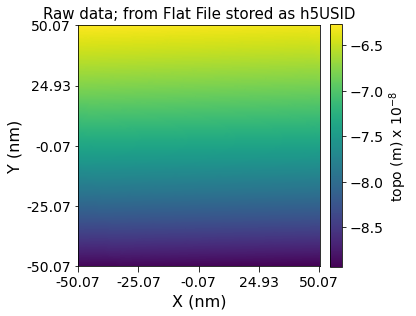

In [25]:
# Use pyUSID to visualise the image
usid.plot_utils.use_nice_plot_params()
fig, axis = h5main.visualize(figsize=(6,6),num_ticks=5)
_ = axis.set_title('Raw data; from Flat File stored as h5USID', fontsize=15)

In [26]:
h5file.close()

### Translating individual mtrx files and visualising

Now I will demonstrate how to translate a single mtrx file using a mtrx parser and visualising this with pyUSID. The matrix parser I used can be found here (https://pypi.org/project/access2theMatrix/). Credits to Dr Steven Schofield for much of the contribution to this method.

In [27]:
# Joining file path and folder path

FolderPath = '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/09-Jun-2017'

FilePath = 'default_2017Jun09-162147_STM-STM_Spectroscopy--1_1.Z_mtrx'

# Make file name including full path 
MTRXFullName = os.path.join(FolderPath, FilePath)
print(MTRXFullName)

/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/09-Jun-2017/default_2017Jun09-162147_STM-STM_Spectroscopy--1_1.Z_mtrx


In [28]:
# Load MTRX file; data and metadata will be stored in python object.
imgBlock, message = mtrx.open(MTRXFullName)
print("Read MTRX file")
print(message)
print(imgBlock)

Read MTRX file
Successfully opened and processed data file default_2017Jun09-162147_STM-STM_Spectroscopy--1_1.Z_mtrx.
{0: 'forward/up', 1: 'backward/up'}


In [29]:
# Select the desired frame from the FU, BU, FD, BD frames
imgPy, message = mtrx.select_image(imgBlock[frame])

# Can use this function to get any of the meta data parameters.
parameters =  mtrx.get_experiment_element_parameters()

The rest of the translation process is pretty similar to the the single flat file translation process. I will still show this for completeness. 

In [30]:
# Define the metadata
numRows = imgPy.data.shape[0]
numCols = imgPy.data.shape[1]
numPos = numRows * numCols
spectraLength = int(0)


yQty = 'Y'
yUnits = 'm'
yVec = np.linspace(0, imgPy.height, numRows, endpoint=True)


xQty = 'X'
xUnits = 'm'
xVec = np.linspace(0, imgPy.width, numCols, endpoint=True)


biasQty = 'None'
biasUnits = 'None'
biasVec = [int(0)]

mainDataName = imgPy.channel_name_and_unit[0]   # "Z"
mainQty = imgPy.channel_name_and_unit[0]
mainUnits = imgPy.channel_name_and_unit[1]

In [31]:
# Convert the data to a numpy array
imgNp = np.asarray(imgPy.data)
imgNp1D = imgNp.reshape(numPos,1)

In [32]:
# Make file name/folders for writing pyUSID/HDF5 "h5USID" format

# Remove .Z_mtrx extension
h5FileName = MTRXFullName[:-7]

# Create h5USID directory for writing the h5USID format image
h5FilePath = '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/09-Jun-2017/h5MTRX'

# Make h5USID file name including full path 
h5FullFileName = os.path.join(h5FilePath, h5FileName + '.h5')

print(h5FullFileName)

/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/09-Jun-2017/default_2017Jun09-162147_STM-STM_Spectroscopy--1_1.h5


In [33]:
# First define the dimensions of our data
posDims = [usid.Dimension(xQty, xUnits, xVec),
            usid.Dimension(yQty, yUnits, yVec)]

specDims = usid.Dimension(biasQty, biasUnits, biasVec)

In [34]:
# Use the pyUSID translator function to write the data to a h5USID file. 
_ = NumPyTran.translate(h5FullFileName, mainDataName,
                   imgNp1D, mainQty, mainUnits,
                   posDims, specDims)
print("Wrote h5USID file: ")
print(_)

Wrote h5USID file: 
/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/09-Jun-2017/default_2017Jun09-162147_STM-STM_Spectroscopy--1_1.h5


In [35]:
# Read back in the h5USID file from disk
h5file = h5py.File(h5FullFileName, mode='r+')
print("Read h5USID file: ", h5FullFileName)

# Plot the data tree structure of the hdf5 file:
sidpy.hdf_utils.print_tree(h5file)  # displays the tree strucutre of the hfd5 (USID) file

Read h5USID file:  /Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/09-Jun-2017/default_2017Jun09-162147_STM-STM_Spectroscopy--1_1.h5
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


In [36]:
# Details of the main dataset
h5main = usid.hdf_utils.get_all_main(h5file)[-1] # Finds all the main data sets. 
print(h5main)

<HDF5 dataset "Raw_Data": shape (4000, 1), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Z (m) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 10 
	X - size: 400 
Spectroscopic Dimensions: 
	None - size: 1
Data Type:
	float64


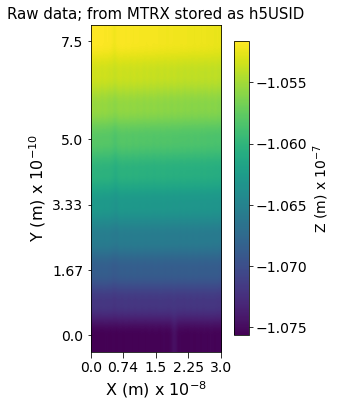

In [37]:
# Use pyUSID to visualise the image
usid.plot_utils.use_nice_plot_params()
fig, axis = h5main.visualize(figsize=(6,6),num_ticks=5)
_ = axis.set_title('Raw data; from MTRX stored as h5USID', fontsize=15)

In [38]:
h5file.close()

### Final comments on translation

I have opted to adopt the first two methods which I have demonstrated as they have a cleaner method for accessing the relavant metadata and generally has much cleaner functions to use. The first method (translation of a folder of flat files) is just a generalisation of the translation of a single flat file to make it easier to translate a large number of flat files at once. This is the method which I will adopt from now. 

# Plane Subtraction

The z-height recorded does not follow a perfectly linear plane so a plane subtracted is applied to the raw data to essentially normalise the z-height data points. This could be done before writing the data to the h5 file, however doing it after allows the demonstration of writing back to the h5 file. 

### Translating flat files

First I will translate some relatively clean flat file images which are complete scans to perform a plane subtraction on. I have identified this by picking the flat files with the largest file size.

In [101]:
# Translating a directory of flat files and storing into a directory and accessing this using an array of filepaths

# Function to record time it takes to run code cell
t0 = time()

FlatFile_dir = '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/Z_Clean'

h5_path_dir = '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5'

# Storing h5 paths into arrays. Have to specify the flat file dir and h5 path dir
h5_path_array = tran.translate(FlatFile_dir, h5_path_dir)

print('Translation took {} seconds.'.format(round(time()-t0, 2)))

Translation took 49.53 seconds.


In [102]:
h5_path_array

['/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--97_1_up-fwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--97_1_up-bwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--97_1_down-fwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--97_1_down-bwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--147_1_up-fwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--147_1_up-bwd.h5',
 '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--147_1_down-fwd.h5',
 '/Users/sulaymand

In [103]:
# Choosing a file path
h5FilePath = h5_path_array[4]

In [104]:
# Opening the file in read and write mode. This is necessary now. 
h5_file = h5py.File(h5FilePath, mode='r+')

print("Read h5USID file: ", h5FilePath)

# Plot the data tree structure of the hdf5 file:
sidpy.hdf_utils.print_tree(h5_file)

Read h5USID file:  /Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/2017_06_09/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--147_1_up-fwd.h5
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


### Performing the plane subtraction

There are many methods to do a plane subtraction. Spiepy (Scanning Probe Image Enchanter using Python) is a Python library to improve automatic processing of SPM images and has a handy plane subtraction function amongst other features. More information can be found here: https://pypi.org/project/SPIEPy/. 

In [105]:
# Identifying the main dataset
h5_main = usid.hdf_utils.get_all_main(h5_file)[-1] # Finds all the main data sets. 
print(h5_main)

<HDF5 dataset "Raw_Data": shape (1000000, 1), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	topo (m) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 1000 
	X - size: 1000 
Spectroscopic Dimensions: 
	None - size: 1
Data Type:
	float64


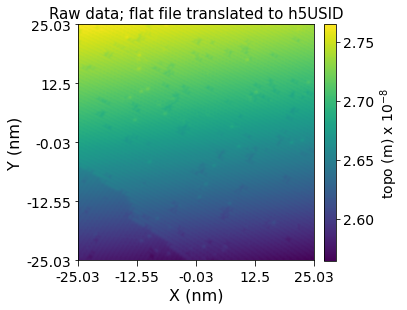

In [106]:
# Use pyUSID to visualise the image
usid.plot_utils.use_nice_plot_params()
fig, axis = h5_main.visualize(figsize=(6,6),num_ticks=5)
_ = axis.set_title('Raw data; flat file translated to h5USID', fontsize=15)

In [107]:
# Get the image data as a numpy array
imgArr = h5_main.get_n_dim_form().squeeze()

In [108]:
imgArr

array([[2.58138797e-08, 2.58143938e-08, 2.58156557e-08, ...,
        2.56516449e-08, 2.56474842e-08, 2.56445377e-08],
       [2.58178980e-08, 2.58189477e-08, 2.58201701e-08, ...,
        2.56542659e-08, 2.56494802e-08, 2.56458940e-08],
       [2.58214545e-08, 2.58225151e-08, 2.58241994e-08, ...,
        2.56517111e-08, 2.56504893e-08, 2.56487692e-08],
       ...,
       [2.76380174e-08, 2.76369284e-08, 2.76345527e-08, ...,
        2.73646091e-08, 2.73639238e-08, 2.73612361e-08],
       [2.76328229e-08, 2.76307249e-08, 2.76293970e-08, ...,
        2.73653813e-08, 2.73639421e-08, 2.73630397e-08],
       [2.76336211e-08, 2.76313882e-08, 2.76303333e-08, ...,
        2.73687709e-08, 2.73687743e-08, 2.73681636e-08]])

I will subtract mean out of the image which will help if I am to do Fast Fourier Transform, but this is optional. 

In [109]:
# Use SPIEpy package to plane subtract the image
imgSub = spiepy.flatten_poly_xy(imgArr, mask=None, deg=1)[0]

# Subtract out the mean of the image
imgSub = imgSub - np.mean(imgSub)  

I will now plot the raw data alongside the plane subtracted data. As I am doing this with raw data and not the pyUSID visualisation functions, I will have to specify the axis information. 

In [110]:
# To plot the data with proper dimensioned x/y axes, we must create axes vectors

# Get information from raw data
xVec = h5_main.get_pos_values('X')   # get x axis vector from h5USID data
yVec = h5_main.get_pos_values('Y')   # get y axis vector from h5USID data
xPixels, yPixels = np.shape(imgArr)  # get pixel count from the numpy raw data
xLength = xVec[-1]
yLength = yVec[-1]
xSamp = xPixels / xLength  # [pixels/nm]
ySamp = yPixels / yLength  # [pixels/nm]
xVec = np.linspace(-xLength / 2, xLength / 2, xPixels)  # vector of locations along x-axis
yVec = np.linspace(-yLength / 2, yLength / 2, yPixels)  # vector of locations along y-axis
xMat, yMat = np.meshgrid(xVec, yVec)  # matrices of x-positions and y-positions

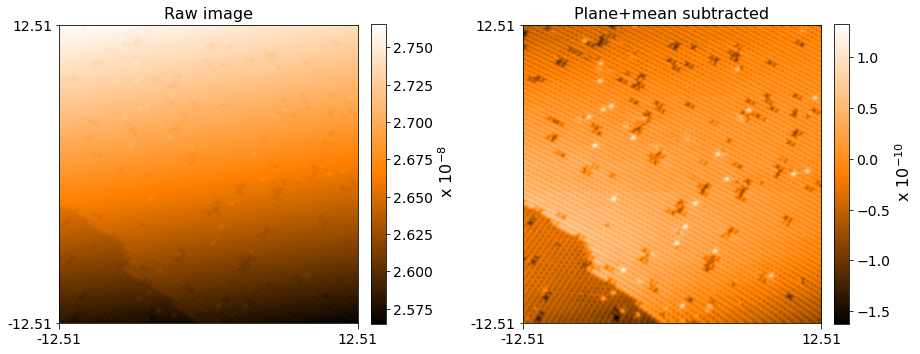

In [111]:
# Use pyUSID routine for plotting the image data
# Note: here we are plotting the 2D numpy array data, not visualising h5USID objects.
# You can thus see differences to the plot above, e.g., no labeled/dimensioned x/y axes.  

fig, axes = plt.subplots(ncols=2, figsize=(13, 8))
for axis, img, title in zip(axes, [imgArr, imgSub], ['Raw image','Plane+mean subtracted']):
    _ = usid.plot_utils.plot_map(axis, img, cmap = spiepy.NANOMAP,
                                 x_vec=xVec, y_vec=yVec, num_ticks=2)
    axis.set_title(title)
fig.tight_layout()

Clearly the image is now a lot cleaner. However, it seems inefficient to have to specify the axis information everytime I want to view the plane subtracted data. Therefore, I will write the plane subtracted data back to the h5 file so I can access the plane subtracted data anytime I want, from any notebook and utilise any of the functions from Pycroscopy/pyUSID/Sidpy on the data.

I could write the plane subtracted data to a new h5 file but this prevents the exploration of the intuitive way of storing multiple datasets in one container, the h5 file.

In [112]:
# First, reshape the mean plane subtracted data

# Extracting shape of position dimension (multiple ways to do this, not necessarily most efficient below)
numX = h5_main.get_n_dim_form().shape[0]
numY = h5_main.get_n_dim_form().shape[1]
numPos = numX * numY

imgSub_1D = imgSub.reshape(numPos, 1)

In [113]:
# Creating a new group to store the plane subtracted data under

## Once run, comment out to prevent creating new group
# h5_results_group_1 = usid.hdf_utils.create_results_group(h5_main, 'Plane-Mean-Subtraction')
print(h5_results_group_1)

<HDF5 group "/Measurement_000/Channel_000/Raw_Data-Plane_Mean_Subtraction_000" (0 members)>


Below I am writing the plane subtracted data as a main dataset. Notice how I have not actually specified the position and spectroscopic deminsions, rather I have specified references to h5_main's position and spectroscopic indices and values. This is one of the advantages of usid and h5. Now both Raw_Data and the plane subtracted data will share the same ancillary datasets. I do not have to rewrite them which saves a lot of memory and shows why h5 is such a powerful container. 

In [114]:
# Writing the plane subtracted data into the h5 file as a MAIN dataset

## Once run, comment out to prevent creating new dataset
# h5_sub = usid.hdf_utils.write_main_dataset(h5_results_group_1,  # parent group
#                                             imgSub_1D,  # data to be written
#                                             'Plane_Mean_Subtracted_Data',  # Name of the main dataset
#                                             'Plane and mean -Subtracted topo',  # quantity
#                                             'm',  # units
#                                             None,  # position dimensions
#                                             None,  # spectroscopic dimensions
#                                             h5_pos_inds=h5_main.h5_pos_inds,
#                                             h5_pos_vals=h5_main.h5_pos_vals,
#                                             h5_spec_inds=h5_main.h5_spec_inds,
#                                             h5_spec_vals=h5_main.h5_spec_vals)

In [115]:
# Printing the tree to verify everything has been written to the file
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Plane_Mean_Subtraction_000
      -----------------------------------
      ├ Plane_Mean_Subtracted_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


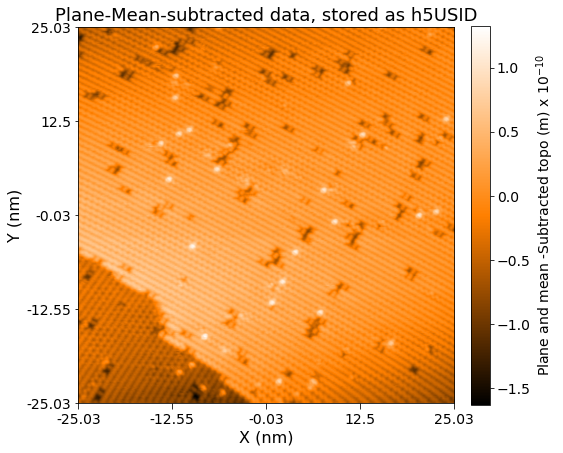

In [117]:
# Get plane and mean subtracted main data
h5Sub_main = usid.hdf_utils.get_all_main(h5_file)[-1] 

# Use pyUSID to visualise the image
usid.plot_utils.use_nice_plot_params()
fig, axis = h5Sub_main.visualize(figsize=(10,10), num_ticks=5, cmap = spiepy.NANOMAP)
_ = axis.set_title('Plane-Mean-subtracted data, stored as h5USID', fontsize=18)

### Final comments on Plane Subtraction